In [41]:
import glob
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import tqdm
import os
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


https://www.kaggle.com/code/raoulma/ny-stock-price-prediction-rnn-lstm-gru/notebook
https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [42]:
df = pd.read_csv('../data/MNQ DEC23.Last-500-Volume-Action.csv')
df.head()

,date,open,high,low,close,vol,ft,action
0,2023-10-02 22:00:38,"14,992.00","14,992.25","14,986.50","14,989.50",500,-0.34,0
1,2023-10-02 22:03:41,"14,989.75","14,992.50","14,988.25","14,990.50",500,-0.06,0
2,2023-10-02 22:08:04,"14,991.00","14,992.75","14,989.50","14,992.00",500,0.40,0
3,2023-10-02 22:13:26,"14,992.00","14,995.00","14,987.75","14,989.75",500,0.20,0
4,2023-10-02 22:14:44,"14,989.75","14,999.00","14,989.75","14,997.50",500,0.45,0


In [43]:
import path

In [44]:
destination_folder = './model/04_trading_lstm'
os.makedirs(destination_folder, exist_ok=True)

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [46]:
scaler = StandardScaler()
scprice = scaler.fit_transform(df[['close']])

In [47]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Metrics loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

def create_dataset(dataset, classes, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
            data: A numpy array of time series
         classes: A numpy array with target variable
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback-1):
        feature = dataset[i:i+lookback]
        target = classes[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [48]:
df

,date,open,high,low,close,vol,ft,action
0,2023-10-02 22:00:38,"14,992.00","14,992.25","14,986.50","14,989.50",500,-0.34,0
1,2023-10-02 22:03:41,"14,989.75","14,992.50","14,988.25","14,990.50",500,-0.06,0
2,2023-10-02 22:08:04,"14,991.00","14,992.75","14,989.50","14,992.00",500,0.40,0
3,2023-10-02 22:13:26,"14,992.00","14,995.00","14,987.75","14,989.75",500,0.20,0
4,2023-10-02 22:14:44,"14,989.75","14,999.00","14,989.75","14,997.50",500,0.45,0
...,...,...,...,...,...,...,...,...
61828,2023-11-01 20:45:32,"14,757.25","14,758.75","14,754.00","14,756.75",500,2.86,0
61829,2023-11-01 20:48:32,"14,756.75","14,759.00","14,753.75","14,754.50",500,2.63,0
61830,2023-11-01 20:53:23,"14,754.50","14,757.00","14,753.00","14,756.00",500,2.53,-1
61831,2023-11-01 20:56:02,"14,756.25","14,760.00","14,753.25","14,755.75",500,2.45,0


In [54]:
lookback = 52
test_size = 2000

ts_price = df[['close']].values.astype('float32')
ts_target = df[['action']].values.astype('float32')

train_size = int(len(ts_price) * 0.67)
test_size = len(ts_price) - train_size
train_price, test_price = ts_price[:train_size], ts_price[train_size:]
train_target, test_taget = ts_target[:train_size], ts_target[train_size:]

In [55]:
X_train, y_train = create_dataset(train_price,train_target, lookback=lookback)
X_test, y_test = create_dataset(test_price, test_taget, lookback=lookback)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# X, Y = create_dataset(dfext.price.values, dfext.target, lookback)

torch.Size([41375, 52, 1]) torch.Size([41375, 1])
torch.Size([20352, 52, 1]) torch.Size([20352, 1])


In [56]:
X_train[0], X_train[1],X_train[2]

(tensor([[14989.5000],
         [14990.5000],
         [14992.0000],
         [14989.7500],
         [14997.5000],
         [14996.0000],
         [15001.0000],
         [15002.7500],
         [15007.7500],
         [15002.2500],
         [14998.0000],
         [14994.2500],
         [14993.5000],
         [14995.0000],
         [14990.5000],
         [14988.2500],
         [14994.0000],
         [14992.2500],
         [14990.5000],
         [14987.2500],
         [14987.5000],
         [14981.7500],
         [14982.2500],
         [14980.5000],
         [14981.0000],
         [14986.2500],
         [14991.2500],
         [14991.0000],
         [14994.5000],
         [15001.0000],
         [14998.2500],
         [14996.7500],
         [14992.7500],
         [14988.7500],
         [14985.0000],
         [14986.7500],
         [14982.7500],
         [14978.7500],
         [14978.2500],
         [14974.7500],
         [14969.7500],
         [14970.0000],
         [14965.2500],
         [1

In [57]:
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=128)
test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=True, batch_size=128)

In [30]:
class MinMaxClassifier(nn.Module):
    def __init__(self, number_of_features, hidden_size, num_layers, out_size, lr):
        super().__init__()
        self.lr = lr
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.out_size    = out_size
        
        self.lstm = nn.LSTM(input_size=number_of_features, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        self.linear1 = nn.Linear(self.hidden_size, 2*self.hidden_size)
        self.drop = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(2*self.hidden_size, self.out_size)
        self.to(device)

    def forward(self, x):
        """ That method is called during the training
        
        Args:
            x: the tensor with data
        """
#         print(x.shape)
#         RuntimeError: input.size(-1) must be equal to input_size. Expected 15, got 1

        x, _ = self.lstm(x)
#         print('Out LSTM', x.shape)
        x = self.linear1(x)
#         print('Linear1', x.shape)
        x = self.drop(x)
#         print('Drop', x.shape)
        x = self.linear2(x)
#         print('Linear2', x.shape)
#         print('before squeeze', x.shape)
#         x = torch.squeeze(x, 1)
#         print('after squeeze', x.shape)
#         x = torch.sigmoid(x)
#         print('sigmoid', x.shape)
        return x[:,-1]

#     def predict(self, inp):
# #         print(inp)
#         logits = self.forward(inp)
# #         x, _ = self.lstm(inp)
# #         logits = self.linear(x)
#         # x = self.softmax(logits).detach().numpy()
#         return np.argmax(logits)
#     def train_step(self, X, y):
# #         print(X, y)
#         y_pred = self.forward(X)
#         loss = self.loss(y_pred, y)
#         loss.backward()
#         self.optimizer.step()
#         self.optimizer.zero_grad()

In [34]:
hidden_size = 50
num_layers = 3
out_size = 1
lr = 0.01
numer_of_features = 1
model = MinMaxClassifier(numer_of_features, hidden_size, num_layers, out_size, lr)
print(model)

MinMaxClassifier(
  (lstm): LSTM(1, 50, num_layers=3, batch_first=True)
  (linear1): Linear(in_features=50, out_features=100, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)


In [10]:
!nvitop


Fri Nov 10 11:04:00 2023
╒═════════════════════════════════════════════════════════════════════════════╕
│ NVIDIA-SMI 525.85.12       Driver Version: 525.85.12       CUDA Version: 12.0     │
├───────────────────────────────┬──────────────────────┬──────────────────────┤
│ GPU  Name        Persistence-M│ Bus-Id        Disp.A │ Volatile Uncorr. ECC │
│ Fan  Temp  Perf  Pwr:Usage/Cap│         Memory-Usage │ GPU-Util  Compute M. │
╞═══════════════════════════════╪══════════════════════╪══════════════════════╡
│   0  NVIDIA GeForce ...  Off  │ 00000000:03:00.0  On │                  N/A │
│  0%   50C    P2   123W / 300W │   6003MiB / 11264MiB │     39%      Default │
╘═══════════════════════════════╧══════════════════════╧══════════════════════╛
[ CPU: ████▌ 15.0%                        ]  ( Load Average:  1.54  1.67  1.40 )
[ MEM: ████▊ 15.7%                        ]  [ SWP: ▏ 0.0%                     ]

╒══════════════════════════════════════════════════════════════════════════════╕
│ Pro

In [35]:
n_epochs = 2000
# def train(model,
#           optimizer,
#           lossfn = nn.BCELoss(),
#           train_loader = train_loader,
#           valid_loader = test_loader,
#           num_epochs = 5,
#           eval_every = len(train_loader) // 2,
#           file_path = destination_folder,
#           best_valid_loss = float("Inf")):
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train(model=model, optimizer=optimizer, num_epochs=10)
lossfn = nn.BCELoss()
train_loader = train_loader
valid_loader = test_loader
num_epochs = n_epochs
eval_every_step = 1000
file_path = destination_folder
best_valid_loss = float("Inf")

# initialize running values
running_loss = 0.0
valid_running_loss = 0.0
global_step = 0
train_loss_list = []
valid_loss_list = []
global_steps_list = []

# training loop
model.train()
for epoch in tqdm.notebook.tqdm_notebook(range(n_epochs)):
    for X_batch, y_batch in train_loader:
#         print("X",len(X_batch), X_batch.shape)
        y_pred = model(X_batch)
        # 64 torch.Size([64, 1])
#         print("y_train", len(y_batch), y_batch.shape)
        # 64 torch.Size([64, 15, 1])
#         print("y_pred",len(y_pred), y_pred.shape)
#         print(y_pred)
        loss = lossfn(y_pred, y_batch) #< 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update running values
        running_loss += loss.item()
        global_step += 1
#         print(global_step, (global_step % eval_every_step)==0)
        # evaluation step
        if (global_step % eval_every_step) == 0:
            model.eval()
            with torch.no_grad():                    
                # validation loop

    #                     for (labels, (title, title_len), (text, text_len), (titletext, titletext_len)), _ in valid_loader:
                for X_batch, y_batch in valid_loader:
                    y_pred = model(X_batch)
                    loss = lossfn(y_pred, y_batch)
                    valid_running_loss += loss.item()

            # evaluation
            average_train_loss = running_loss / eval_every_step
            average_valid_loss = valid_running_loss / len(valid_loader)
            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)
            global_steps_list.append(global_step)

            # resetting running values
            running_loss = 0.0                
            valid_running_loss = 0.0
            model.train()

            # print progress
            print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                  .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                          average_train_loss, average_valid_loss))

            # checkpoint
            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
print('Finished Training!')





Epoch [48/2000], Step [1000/42000], Train Loss: nan, Valid Loss: 0.3200
Model saved to ==> ./model/04_trading_lstm/model.pt
Model saved to ==> ./model/04_trading_lstm/metrics.pt
Epoch [96/2000], Step [2000/42000], Train Loss: nan, Valid Loss: 0.3437
Epoch [143/2000], Step [3000/42000], Train Loss: nan, Valid Loss: 0.3459
Epoch [191/2000], Step [4000/42000], Train Loss: nan, Valid Loss: 0.3459
Epoch [239/2000], Step [5000/42000], Train Loss: nan, Valid Loss: 0.5564
Epoch [286/2000], Step [6000/42000], Train Loss: 0.5659, Valid Loss: 0.5564
Epoch [334/2000], Step [7000/42000], Train Loss: 0.5657, Valid Loss: 0.5562
Epoch [381/2000], Step [8000/42000], Train Loss: 0.5657, Valid Loss: 0.5559
Epoch [429/2000], Step [9000/42000], Train Loss: 0.5653, Valid Loss: 0.5553
Epoch [477/2000], Step [10000/42000], Train Loss: 0.5644, Valid Loss: 0.5542
Epoch [524/2000], Step [11000/42000], Train Loss: 0.5629, Valid Loss: 0.5524
Epoch [572/2000], Step [12000/42000], Train Loss: 0.5605, Valid Loss: 0.5

In [38]:
len(global_steps_list)

42

Model loaded from <== ./model/04_trading_lstm/metrics.pt


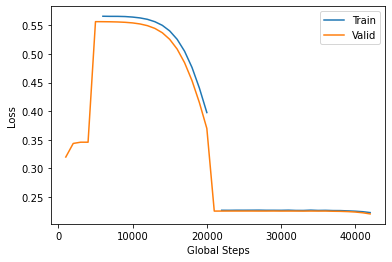

In [36]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [1]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(y_batch.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
best_model = MinMaxClassifier(numer_of_features, hidden_size, num_layers, out_size, lr).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_loader)

NameError: name 'MinMaxClassifier' is not defined